<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Black-Scholes-Model" data-toc-modified-id="Black-Scholes-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Black-Scholes Model</a></span></li><li><span><a href="#Binomial-Tree-Model" data-toc-modified-id="Binomial-Tree-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Binomial Tree Model</a></span></li><li><span><a href="#Explicit-Finite-Differential" data-toc-modified-id="Explicit-Finite-Differential-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Explicit Finite Differential</a></span></li></ul></div>

## Black-Scholes Model

In [40]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import warnings 
warnings.filterwarnings('ignore')

In [54]:
def bs_price(S, K, r, q, T, sigma, option = 'call'):

    d1 = (np.log(S/K) + (r-q+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S/K) + (r-q-0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    
    if option == 'call':
        result = (S*np.exp(-q*T)*si.norm.cdf(d1, 0.0, 1.0) - K*np.exp(-r*T)*si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K*np.exp(-r*T)*si.norm.cdf(-d2, 0.0, 1.0) - S*np.exp(-q*T)*si.norm.cdf(-d1, 0.0, 1.0))        
    
    return result

In [55]:
S = 100
K = 100
r = 0.05
q = 0
T = 1/2
sigma = 0.20

In [59]:
call_price = bs_price(S, K, r, q, T, sigma, option = 'call')
put_price = bs_price(S, K, r, q, T, sigma, option = 'put')
print('================================')
print('Black-Scholes call price:', format(call_price, '.4f'))
print('================================')
print('Black-Scholes put price :' , format(put_price, '.4f'))
print('================================')

Black-Scholes call price: 6.8887
Black-Scholes put price : 4.4197


## Binomial Tree Model

In [48]:
def binomialEuropean(S, K, r, T, sigma, n=100, option='call'):
    deltaT = T/n
    u = np.exp(sigma * np.sqrt(deltaT))
    d = 1.0 / u
    a = np.exp(r*deltaT)
    q = (a-d) / (u-d)
    Sv = np.zeros((n, n))
    V = np.zeros((n, n))
    
    for j in range(n):
        for i in range(j+1):
            Sv[i, j] = S * u**i * d**(j-i)
            
    if option == 'call':
        CorP = 1
    if option == 'put':
        CorP = -1
    V[:, -1] = np.maximum((Sv[:, -1]-K)*CorP, 0)

    for j in reversed(range(n-1)):
        for i in range(j+1):
            V[i, j] = np.exp(-r*deltaT)*(q*V[i+1, j+1]+(1.0-q)*V[i, j+1])
            
    return Sv, V, V[0, 0]

In [49]:
n = 4

In [53]:
call_bin = binomialEuropean(S,K,r,T,sigma,n,option = 'call')
put_bin = binomialEuropean(S,K,r,T,sigma,n,option = 'put')
call_bin_price = call_bin[2]
put_bin_price = put_bin[2]
print('====================================')
print('Binomial European call price:', '%.4f' %call_bin_price)
print('====================================')
print('Binomial European put price :',  '%.4f' %put_bin_price)
print('====================================')

Binomial European call price: 6.2194
Binomial European put price : 4.3619


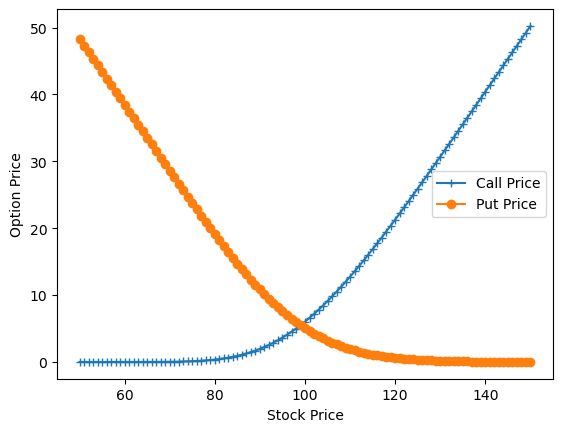

In [29]:
M = 101
Svec = np.linspace(50, 150, M)
Cvec = bs_price(Svec, K, r , q , T, sigma, option = 'call')
Pvec = bs_price(Svec, K, r , q , T, sigma, option = 'put')
plt.plot(Svec, Cvec, '+-', label = 'Call Price')
plt.plot(Svec, Pvec, 'o-', label = 'Put Price')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.legend()
plt.show()

## Explicit Finite Differential

In [30]:
S = 100
K = 100
r = 0.05
T = 1/2
sigma = 0.2
Smax = 150
dS = 4
dt = 5/1200

In [31]:
def EFD_European(S, K, r, T, sigma, Smax, dS, dt, option='call'):
    
    M = np.int(np.round(Smax/dS))
    dS = Smax/M
    N = np.int(np.round(T/dt))
    dt = T/N
    
    V = np.zeros((M+1,N+1))
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    if option == 'call':
        V[:,-1] = np.maximum(Sv-K,0)
        V[0,:] = 0
        V[M,:] = Smax-K*np.exp(-r*dt*(N-jv))
        
    if option == 'put':
        V[:,-1] = np.maximum(K-Sv,0)
        V[0,:] = K*np.exp(-r*dt*(N-jv))
        V[M,:] = 0

    a = 0.5*dt*((sigma**2)*iv - (r-q))*iv
    b = 1-dt*((sigma**2)*(iv**2) + r)
    c = 0.5*dt*((sigma**2)*iv + (r-q))*iv
    
    for j in reversed(np.arange(N)):
        for i in np.arange(1,M):
            V[i,j] = a[i]*V[i-1,j+1]+b[i]*V[i,j+1]+c[i]*V[i+1,j+1]
                        
    f_interp = interp1d(Sv, V[:,0], kind = 'cubic')
    price = f_interp(S)
    
    return [Sv, V[:,0], price]    

In [64]:
Call = EFD_European(S, K, r, T, sigma, Smax, dS, dt, option='call')

call_bs = bs_price(S, K, r, q, T, sigma, option = 'call')
call_fd = Call[2]

print('======================')
print('BS  call price:', format(call_bs, '.4f'))
print('======================')
print('EFD call price:', format(call_fd, '.4f'))
print('======================')

BS  call price: 6.8887
EFD call price: 6.8873


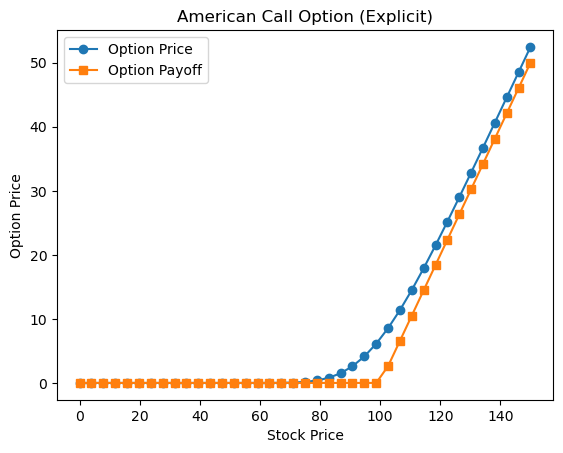

In [65]:
S_fdCall = Call[0]
V_fdCall = Call[1]

plt.plot(S_fdCall, V_fdCall, 'o-', label='Option Price')
plt.plot(S_fdCall, np.maximum(S_fdCall-K, 0), 's-', label='Option Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('American Call Option (Explicit)')
plt.legend()
plt.show()

In [66]:
Put = EFD_European(S, K, r, T, sigma, Smax, dS, dt, option='put')

put_bs = bs_price(S, K, r, q, T, sigma, option = 'put')
put_fd = Put[2]

print('======================')
print('BS  put price:', format(put_bs, '.4f'))
print('======================')
print('EFD put price:', format(put_fd, '.4f'))
print('======================')

BS  put price: 4.4197
EFD put price: 4.4180


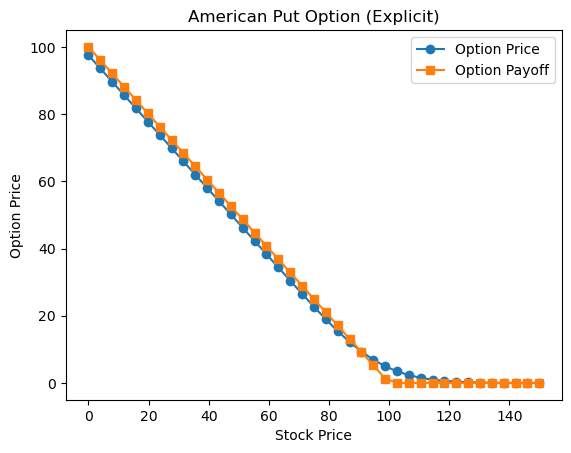

In [67]:
S_fdPut = Put[0]
V_fdPut = Put[1]

plt.plot(S_fdPut, V_fdPut, 'o-', label='Option Price')
plt.plot(S_fdPut, np.maximum(K-S_fdPut, 0), 's-', label='Option Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('American Put Option (Explicit)')
plt.legend()
plt.show()